In [1]:
# Importing the libraries 
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import pandas as pd
from torchsummary import summary

# Checking the availability of CUDA on machine
print("Torch", torch.__version__, "CUDA", torch.version.cuda)
print("Device:", torch.device("cuda:0"))
print(torch.cuda.is_available())

Torch 1.0.0 CUDA 9.0
Device: cuda:0
True


In [2]:
epochs = 50

In [3]:
# Loading the data taking 200 at a time
BATCH = 200
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

train_set = torchvision.datasets.MNIST(
    "mnist_data", transform=transform, train=True, download=True
)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH)

test_set = torchvision.datasets.MNIST(
    "mnist_data", transform=transform, train=False, download=True,
)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH)

In [4]:
# I learning Pytorch using the following playlist on youtube
# A part of this code in this cell is take from those learning
# https://www.youtube.com/watch?v=v5cngxo4mIg&list=PLZbbT5o_s2xrfNyHZsM6ufI0iZENK9xgG
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.input_layer = nn.Linear(28 * 28, 1024)
        self.hidden_layer1 = nn.Linear(1024, 1024)
        self.hidden_layer2 = nn.Linear(1024, 1024)
        self.hidden_layer3 = nn.Linear(1024, 1024)
        self.hidden_layer4 = nn.Linear(1024, 1024)
        self.output_layer = nn.Linear(1024, 10)
        self.activation = nn.ReLU()

    def forward(self, data):
        data = data.view(-1, 28 * 28).cuda()
        self.data = data
        self.output_input_layer = self.activation(self.input_layer(data))
        self.output_1st_hidden = self.activation(
            self.hidden_layer1(self.output_input_layer)
        )
        self.output_2nd_hidden = self.activation(
            self.hidden_layer2(self.output_1st_hidden)
        )
        self.output_3rd_hidden = self.activation(
            self.hidden_layer3(self.output_2nd_hidden)
        )
        self.output_4th_hidden = self.activation(
            self.hidden_layer4(self.output_3rd_hidden)
        )
        self.final_output = self.output_layer(self.output_4th_hidden)
        self.softmax_output = torch.nn.functional.log_softmax(self.final_output, dim=1)
        return self.softmax_output



In [5]:
neural_network = NeuralNet().cuda()
summary(neural_network, (28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]         803,840
              ReLU-2                 [-1, 1024]               0
            Linear-3                 [-1, 1024]       1,049,600
              ReLU-4                 [-1, 1024]               0
            Linear-5                 [-1, 1024]       1,049,600
              ReLU-6                 [-1, 1024]               0
            Linear-7                 [-1, 1024]       1,049,600
              ReLU-8                 [-1, 1024]               0
            Linear-9                 [-1, 1024]       1,049,600
             ReLU-10                 [-1, 1024]               0
           Linear-11                   [-1, 10]          10,250
Total params: 5,012,490
Trainable params: 5,012,490
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

tensor(0.0004, device='cuda:0')


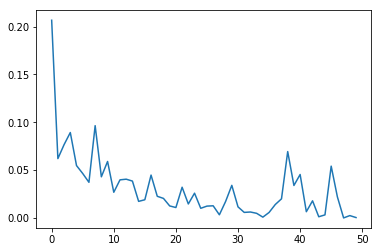

In [6]:
#Training the network

loss_function = nn.CrossEntropyLoss()
para = neural_network.parameters()
optimizer = torch.optim.Adam(para, lr=0.001)
loss_list = []
for t in range(epochs):
    for i, data in enumerate(train_loader):
        images, labels = data
        optimizer.zero_grad()
        outputs = neural_network(images.cuda())
        loss = loss_function(outputs.cuda(), labels.cuda())
        loss.backward()
        optimizer.step()
# For debugging purpose
    loss_list.append(loss.data.cpu().numpy())
# For debugging purpose
print(loss.data)
plt.plot(range(epochs), loss_list)
plt.show()  



In [7]:
# Testing the trained model
def test(model):
    correct = 0
    total = 0
    save_one = 0

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data.cuda(), 1)
            _ = _.cuda()
            predicted = predicted.cuda()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
#     print(correct)
    acc = (100.0 * correct / total)
    print("Accuracy:" , acc)
    return acc

In [8]:
print("Accuracy with original model")
test(neural_network)

Accuracy with original model
Accuracy: 98.25


98.25

In [9]:
w1 = neural_network.input_layer.weight.data
w2 = neural_network.hidden_layer1.weight.data
w3 = neural_network.hidden_layer2.weight.data
w4 = neural_network.hidden_layer3.weight.data
w5 = neural_network.hidden_layer4.weight.data
w_last_layer = neural_network.output_layer.weight.data

In [10]:
u1,s1,v1 = torch.svd(w1)
u2,s2,v2 = torch.svd(w2)
u3,s3,v3 = torch.svd(w3)
u4,s4,v4 = torch.svd(w4)
u5,s5,v5 = torch.svd(w5)
state_dict = neural_network.state_dict()

In [11]:
d= [10,20,50,100,200, 'full']
acc_list = []
for item in d:
    print()
    if item != 'full':
        w1_new = torch.mm(u1[:,0:item],torch.mm(s1.diag()[0:item,0:item],v1[:,0:item].t()))
        w2_new = torch.mm(u2[:,0:item],torch.mm(s2.diag()[0:item,0:item],v2[:,0:item].t()))
        w3_new = torch.mm(u3[:,0:item],torch.mm(s3.diag()[0:item,0:item],v3[:,0:item].t()))
        w4_new = torch.mm(u4[:,0:item],torch.mm(s4.diag()[0:item,0:item],v4[:,0:item].t()))
        w5_new = torch.mm(u5[:,0:item],torch.mm(s5.diag()[0:item,0:item],v5[:,0:item].t()))
    else:
        w1_new = torch.mm(u1,torch.mm(s1.diag(),v1.t()))
        w2_new = torch.mm(u2,torch.mm(s2.diag(),v2.t()))
        w3_new = torch.mm(u3,torch.mm(s3.diag(),v3.t()))
        w4_new = torch.mm(u4,torch.mm(s4.diag(),v4.t()))
        w5_new = torch.mm(u5,torch.mm(s5.diag(),v5.t()))
    print(w1_new.shape)
        
    state_dict['input_layer.weight'] = w1_new
    state_dict['hidden_layer1.weight'] = w2_new
    state_dict['hidden_layer2.weight'] = w3_new
    state_dict['hidden_layer3.weight'] = w4_new
    state_dict['hidden_layer4.weight'] = w5_new
    
    neural_network.load_state_dict(state_dict)
    print("Accuracy when d is ", item)
    acc = test(neural_network)
    acc_list.append(acc)


torch.Size([1024, 784])
Accuracy when d is  10
Accuracy: 49.94

torch.Size([1024, 784])
Accuracy when d is  20
Accuracy: 93.15

torch.Size([1024, 784])
Accuracy when d is  50
Accuracy: 97.95

torch.Size([1024, 784])
Accuracy when d is  100
Accuracy: 98.18

torch.Size([1024, 784])
Accuracy when d is  200
Accuracy: 98.21

torch.Size([1024, 784])
Accuracy when d is  full
Accuracy: 98.25


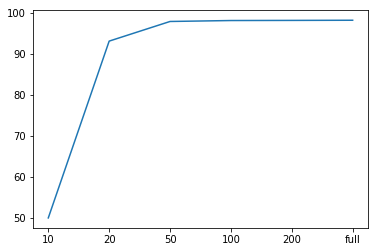

In [12]:
plt.plot(d,acc_list)

In [13]:
# setting d = 20
item = 20
u1, v_hat1 = u1[:,0:item] , torch.mm(s1.diag()[0:item,0:item],v1[:,0:item].t())
u2, v_hat2 = u2[:,0:item] , torch.mm(s2.diag()[0:item,0:item],v2[:,0:item].t())
u3, v_hat3 = u3[:,0:item] , torch.mm(s3.diag()[0:item,0:item],v3[:,0:item].t())
u4, v_hat4 = u4[:,0:item] , torch.mm(s4.diag()[0:item,0:item],v4[:,0:item].t())
u5, v_hat5 = u5[:,0:item] , torch.mm(s5.diag()[0:item,0:item],v5[:,0:item].t())

class NeuralNet_Compressed(nn.Module):
    def __init__(self):
        super(NeuralNet_Compressed, self).__init__()
        
        self.layer_v_hat1 = nn.Linear(28*28, 20)
        self.layer_u1 = nn.Linear(20, 1024)
        
        self.layer_v_hat2 = nn.Linear(1024, 20)
        self.layer_u2 = nn.Linear(20, 1024)
        
        self.layer_v_hat3 = nn.Linear(1024, 20)
        self.layer_u3 = nn.Linear(20, 1024)
        
        self.layer_v_hat4 = nn.Linear(1024, 20)
        self.layer_u4 = nn.Linear(20, 1024)
        
        self.layer_v_hat5 = nn.Linear(1024, 20)
        self.layer_u5 = nn.Linear(20, 1024)
        
        
        self.output_layer = nn.Linear(1024, 10)
        self.activation = nn.ReLU()

    def forward(self, data):
        data = data.view(-1, 28 * 28).cuda()
        self.data = data
        
        self.output = self.activation(self.layer_v_hat1(data))
        
        self.output = self.activation(
            self.layer_u1(self.output)
        )
        
        self.output = self.activation(
            self.layer_v_hat2(self.output)
        )
        
        self.output = self.activation(
            self.layer_u2(self.output)
        )
        self.output = self.activation(
            self.layer_v_hat3(self.output)
        )
        
        self.output = self.activation(
            self.layer_u3(self.output)
        )
        self.output = self.activation(
            self.layer_v_hat4(self.output)
        )
       
        self.output = self.activation(
            self.layer_u4(self.output)
        )
        
        self.output = self.activation(
            self.layer_v_hat5(self.output)
        )
        
        self.output = self.activation(
            self.layer_u5(self.output)
        )
      
        
        self.final_output = self.output_layer(self.output)
        self.softmax_output = torch.nn.functional.log_softmax(self.final_output, dim=1)
        return self.softmax_output

model_compressed = NeuralNet_Compressed().cuda()


state_dict = model_compressed.state_dict()

state_dict['layer_v_hat1.weight'] = v_hat1
state_dict['layer_u1.weight'] = u1

state_dict['layer_v_hat2.weight'] = v_hat2
state_dict['layer_u2.weight'] = u2

state_dict['layer_v_hat3.weight'] = v_hat3
state_dict['layer_u3.weight'] = u3

state_dict['layer_v_hat4.weight'] = v_hat4
state_dict['layer_u4.weight'] = u4

state_dict['layer_v_hat5.weight'] = v_hat5
state_dict['layer_u5.weight'] = u5

state_dict['output_layer.weight'] = w_last_layer


model_compressed.load_state_dict(state_dict)

In [14]:
summary(model_compressed, (28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 20]          15,700
              ReLU-2                   [-1, 20]               0
            Linear-3                 [-1, 1024]          21,504
              ReLU-4                 [-1, 1024]               0
            Linear-5                   [-1, 20]          20,500
              ReLU-6                   [-1, 20]               0
            Linear-7                 [-1, 1024]          21,504
              ReLU-8                 [-1, 1024]               0
            Linear-9                   [-1, 20]          20,500
             ReLU-10                   [-1, 20]               0
           Linear-11                 [-1, 1024]          21,504
             ReLU-12                 [-1, 1024]               0
           Linear-13                   [-1, 20]          20,500
             ReLU-14                   

In [15]:
loss_function = nn.CrossEntropyLoss()
para = model_compressed.parameters()
optimizer = torch.optim.Adam(para, lr=0.001)
loss_list = []
for t in range(epochs):
    for i, data in enumerate(train_loader):
        images, labels = data
        optimizer.zero_grad()
        outputs = model_compressed(images.cuda())
        loss = loss_function(outputs.cuda(), labels.cuda())
        loss.backward()
        optimizer.step()

In [16]:
test(model_compressed)

Accuracy: 96.93


96.93